# Data Preprocessing

The following notebook involves process of 
- Data Ingestion (Data Downloading and loading)
- Splitting data into train and test split
- Exploring data
- Preprocessing it to be fed into the model

## Importing Libraries

In [1]:
import pandas as pd
import os
import urllib.request
import pathlib
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import BertTokenizer
import re

## Hyperparameters and global variables

In [2]:
DATASET_URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
base_path = pathlib.Path('../datasets')
file_name = 'article_category.csv'
valid_split, test_split = 0.2, 0.2
train_split = 1 - (valid_split + test_split)
seed = 42

## Loading and downloading data

In [3]:
def download_data(URL, base_path, file_name = 'dataset.csv'):
    path = base_path/file_name
    if not path.is_file():
        urllib.request.urlretrieve(URL, path)
    return path

In [4]:
data_path = download_data(DATASET_URL, base_path, file_name)
df = pd.read_csv(data_path)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           764 non-null    int64 
 1   created_on   764 non-null    object
 2   title        764 non-null    object
 3   description  764 non-null    object
 4   tag          764 non-null    object
dtypes: int64(1), object(4)
memory usage: 30.0+ KB


In [6]:
# Splitting data
train_data, valid_test_data = train_test_split(df, train_size=train_split, 
                                               random_state=seed, stratify=df['tag'])
valid_data, test_data = train_test_split(valid_test_data, train_size=valid_split/(valid_split+test_split), 
                                         random_state=seed, stratify=valid_test_data['tag'])

print(f'Number of Training samples: {len(train_data)}')
print(f'Number of Validation samples: {len(valid_data)}')
print(f'Number of Testing samples: {len(test_data)}')

Number of Training samples: 458
Number of Validation samples: 153
Number of Testing samples: 153


Verify that the distribution of output is same across the split. (This is done by specifying the stratify)

In [7]:
train_distribution = pd.DataFrame(train_data['tag'].value_counts(normalize = True)).reset_index()
train_distribution.columns = ['Tag-Category', 'Train']

valid_distribution = pd.DataFrame(valid_data['tag'].value_counts(normalize = True)).reset_index()
valid_distribution.columns = ['Tag-Category', 'valid']

test_distribution = pd.DataFrame(test_data['tag'].value_counts(normalize = True)).reset_index()
test_distribution.columns = ['Tag-Category', 'test']

In [8]:
test_distribution

,Tag-Category,test
0,natural-language-processing,0.405229
1,computer-vision,0.372549
2,other,0.137255
3,mlops,0.084967


In [9]:
all_distribution = train_distribution.join(valid_distribution.set_index('Tag-Category'), 
                                           on = 'Tag-Category').join(
                                               test_distribution.set_index('Tag-Category'), 
                                               on = 'Tag-Category')
all_distribution.head()

,Tag-Category,Train,valid,test
0,natural-language-processing,0.406114,0.405229,0.405229
1,computer-vision,0.373362,0.372549,0.372549
2,other,0.137555,0.143791,0.137255
3,mlops,0.082969,0.078431,0.084967


In [10]:
all_distribution_melt = all_distribution.melt(id_vars='Tag-Category', var_name='split')
all_distribution_melt.head()

,Tag-Category,split,value
0,natural-language-processing,Train,0.406114
1,computer-vision,Train,0.373362
2,other,Train,0.137555
3,mlops,Train,0.082969
4,natural-language-processing,valid,0.405229


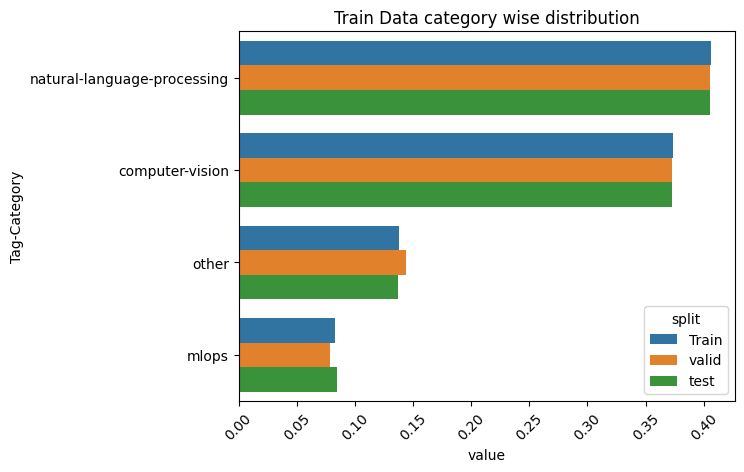

In [11]:
sns.barplot(all_distribution_melt, y = 'Tag-Category', x = 'value', hue = 'split')
plt.tick_params('x', rotation=45)
plt.title('Train Data category wise distribution');

So we can clearly see that the split result in similar distribution of each category

## EDA (Exploratory Data analysis)

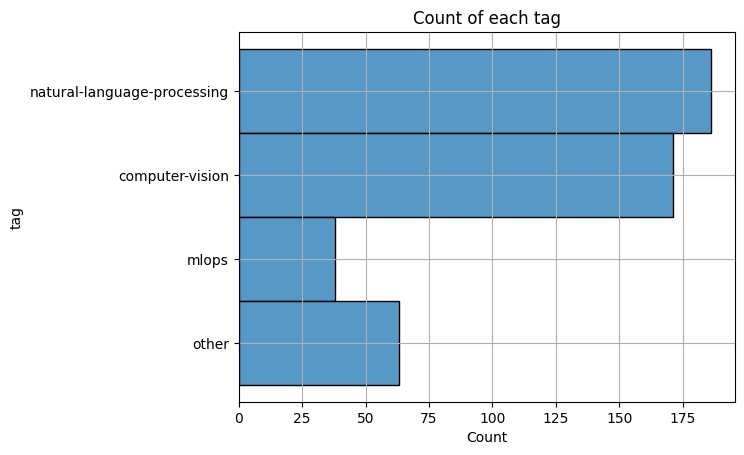

In [12]:
# Check whether the data is balanced or imbalanced
sns.histplot(train_data, y = 'tag')
plt.title('Count of each tag')
plt.grid(True);

__NOTE:__ It is clearly observable that the data is imbalanced (2 classes are dominant). This insight will help us to choose appropriate loss function and techniques to take this into account. Also, metric chosen for the task should be appropriate for assessing correct performance in this imbalanced case

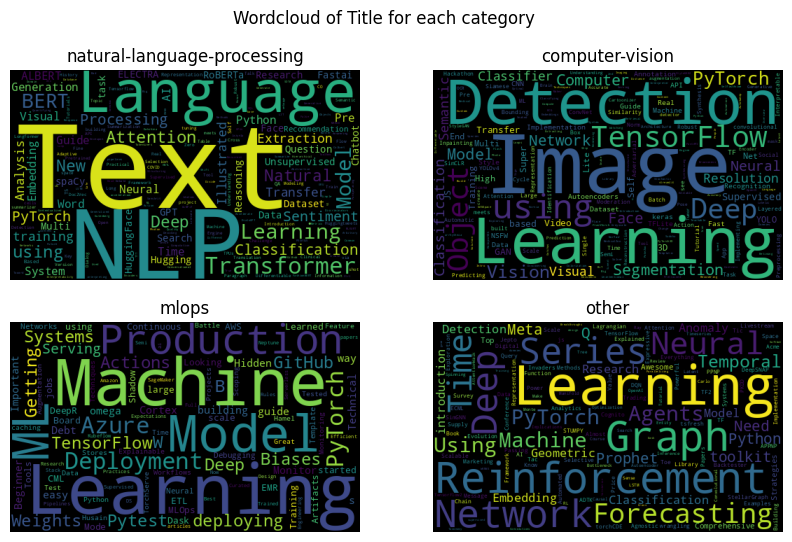

In [13]:
fig, axes = plt.subplots(nrows = 2, ncols=2, figsize = (10,6))
plot_idx = 0
for tag in train_data['tag'].unique():
    subset = train_data[train_data['tag']==tag]
    text = subset['title'].values
    cloud = WordCloud(stopwords=STOPWORDS, collocations=False, width=500, height=300).generate(" ".join(text))
    row_num, col_num = plot_idx//2, plot_idx%2
    axes[row_num, col_num].imshow(cloud)
    axes[row_num, col_num].axis("off")
    axes[row_num, col_num].set_title(tag)
    plot_idx+=1

plt.suptitle('Wordcloud of Title for each category');

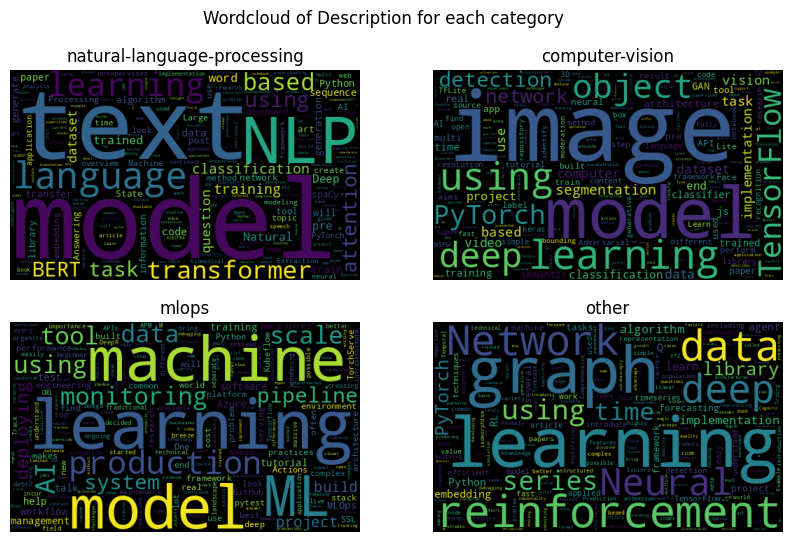

In [14]:
fig, axes = plt.subplots(nrows = 2, ncols=2, figsize = (10,6))
plot_idx = 0
for tag in train_data['tag'].unique():
    subset = train_data[train_data['tag']==tag]
    text = subset['description'].values
    cloud = WordCloud(stopwords=STOPWORDS, collocations=False, width=500, height=300).generate(" ".join(text))
    row_num, col_num = plot_idx//2, plot_idx%2
    axes[row_num, col_num].imshow(cloud)
    axes[row_num, col_num].axis("off")
    axes[row_num, col_num].set_title(tag)
    plot_idx+=1

plt.suptitle('Wordcloud of Description for each category');

On carefully observing the wordcloud for each category, it is quiet evident that the description and title talks about something which can help us directly infer the tag from it. For eg: Natural-language-processing tags mainly talks about text, NLP, etc. which is what natural-language-processing is all about

## Data Preprocessing

Preprocessing is generally did to transform our data into the required format which can readily be fed into the model. Since this is a textual data containing features in two columns (title and description), the following operations can be performed to make it ready for model:

- Feature Engineering (Since, we know that both the text and description is important for classification, we can combine them together to form a large text for classification.)
- Cleaning (Since the task is only classification, stopwords, punctuations, etc. can be removed easily which doesn't contribute much to the classification of tag)
- Encoding (Encode the labels into numerical category to be fed into the model for classification)
- Tokenize (Tokenize our text to have numerical representation, pretrained scientific bert tokenizer is used so that open source available model can be used rather than train from scratch).

Entire pipeline should have corresponding functions so that these module can function independently and can be applied directly to incoming stream of data.

### Feature Engineering

In [15]:
def combine_title_desc(data):
    data['text'] = data['title'] + " " + data['description']
    return data

train_data.head()

,id,created_on,title,description,tag
139,466,2020-04-13 18:48:40,Tokenizers: How Machines Read,A survey of different tokenization strategies ...,natural-language-processing
56,234,2020-04-06 17:42:52,An Overview of Semantic Image Segmentation,Image segmentation is a computer vision task i...,computer-vision
295,941,2020-05-22 03:21:10,BiT: Exploring Large-Scale Pre-training for Co...,We are excited to share the best BiT models pr...,computer-vision
155,490,2020-04-14 22:35:21,U-Net Deep Learning Colorization of Greyscale ...,This article describes experiments training a ...,computer-vision
423,1457,2020-06-16 02:46:25,Synthesizing High-Resolution Images with Styl...,"Developed by NVIDIA Researchers, StyleGAN2 yie...",computer-vision


In [16]:
train_data = combine_title_desc(train_data)
train_data.head()

,id,created_on,title,description,tag,text
139,466,2020-04-13 18:48:40,Tokenizers: How Machines Read,A survey of different tokenization strategies ...,natural-language-processing,Tokenizers: How Machines Read A survey of diff...
56,234,2020-04-06 17:42:52,An Overview of Semantic Image Segmentation,Image segmentation is a computer vision task i...,computer-vision,An Overview of Semantic Image Segmentation Ima...
295,941,2020-05-22 03:21:10,BiT: Exploring Large-Scale Pre-training for Co...,We are excited to share the best BiT models pr...,computer-vision,BiT: Exploring Large-Scale Pre-training for Co...
155,490,2020-04-14 22:35:21,U-Net Deep Learning Colorization of Greyscale ...,This article describes experiments training a ...,computer-vision,U-Net Deep Learning Colorization of Greyscale ...
423,1457,2020-06-16 02:46:25,Synthesizing High-Resolution Images with Styl...,"Developed by NVIDIA Researchers, StyleGAN2 yie...",computer-vision,Synthesizing High-Resolution Images with Styl...


### Data Cleaning

In [17]:
# Other not useful columns can be removed

def remove_columns(data):
    data = data.drop(['id', 'created_on', 'title', 'description'], axis = 1)
    return data

train_data = remove_columns(train_data)
train_data.head()

,tag,text
139,natural-language-processing,Tokenizers: How Machines Read A survey of diff...
56,computer-vision,An Overview of Semantic Image Segmentation Ima...
295,computer-vision,BiT: Exploring Large-Scale Pre-training for Co...
155,computer-vision,U-Net Deep Learning Colorization of Greyscale ...
423,computer-vision,Synthesizing High-Resolution Images with Styl...


In [18]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')

def clean_data(text, STOPWORDS = STOPWORDS):

    # Make all to lower case (case is not much important here since the focus is the terms used)
    text = text.lower()

    # Remove all stop words
    pattern = re.compile(r'\b(' + '|'.join(STOPWORDS) + ')\b\s*')
    text = pattern.sub(' ', text)

    # Note: \b stands for non character boundary
    # Note: STOPWORDS will be joined in single string separated by | 
    # which is used by regex for or operation (i.e. search for either word)

    # Separate all punctuation 
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", " \1 ", text)

    # look for the punctuation in between [ ] and then replace it surrounded by space
    # \1 is used to refer to matched character

    # Remove all non alphanumeric words
    text = re.sub(r'[^a-z0-9]', ' ', text)

    # Remove any possible link
    text = re.sub(r'http(s)?\S+', ' ', text)

    # Remove redundant spaces
    text = re.sub(r'\s+', ' ', text)

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /raid/biplab/aniket/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
idx = 2
current_text = train_data['text'].iloc[idx]
print('***** Before Cleaning *****')
print(current_text)
current_text_cleaned = clean_data(current_text, STOPWORDS)
print('***** After Cleaning *****')
print(current_text_cleaned)

***** Before Cleaning *****
BiT: Exploring Large-Scale Pre-training for Compute We are excited to share the best BiT models pre-trained on public datasets, along with code in TF2, Jax, and PyTorch. 
***** After Cleaning *****
bit exploring large scale pre training for compute we are excited to share the best bit models pre trained on public datasets along with code in tf2 jax and pytorch 


In [20]:
# Applying the function on entire dataset
train_data['text'] = train_data['text'].apply(clean_data)
train_data.head()

,tag,text
139,natural-language-processing,tokenizers how machines read a survey of diffe...
56,computer-vision,an overview of semantic image segmentation ima...
295,computer-vision,bit exploring large scale pre training for com...
155,computer-vision,u net deep learning colorization of greyscale ...
423,computer-vision,synthesizing high resolution images with styl...


In [21]:
train_data.info() # No null data

<class 'pandas.core.frame.DataFrame'>
Index: 458 entries, 139 to 704
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tag     458 non-null    object
 1   text    458 non-null    object
dtypes: object(2)
memory usage: 10.7+ KB


### Encoding

In [22]:
tags = train_data['tag'].unique().tolist()
tag_2_idx = {tag:idx for idx, tag in enumerate(tags)}
idx_2_tag = {idx:tag for tag, idx in tag_2_idx.items()}
print(tag_2_idx)
print(idx_2_tag)

{'natural-language-processing': 0, 'computer-vision': 1, 'mlops': 2, 'other': 3}
{0: 'natural-language-processing', 1: 'computer-vision', 2: 'mlops', 3: 'other'}


In [23]:
def encode_tags(data):
    data['tag'] = data['tag'].map(tag_2_idx)
    return data

train_data = encode_tags(train_data)
train_data.head()

,tag,text
139,0,tokenizers how machines read a survey of diffe...
56,1,an overview of semantic image segmentation ima...
295,1,bit exploring large scale pre training for com...
155,1,u net deep learning colorization of greyscale ...
423,1,synthesizing high resolution images with styl...


### Tokenize the text

In [24]:
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)

In [25]:
idx = 2
current_text = train_data['text'].iloc[idx]

encoded_inputs = tokenizer([current_text], return_tensors='np', padding='longest')

print('**** Encoded Information ****')
print ('input_ids:', encoded_inputs['input_ids'])
print ('attention_mask:', encoded_inputs['attention_mask'])

print('**** Decoded Information ****')
print (tokenizer.decode(encoded_inputs['input_ids'][0]))

**** Encoded Information ****
input_ids: [[  102  4626 12038  1135  2211   382  2208   168  4677   185   220 10982
    147  4456   111  2172  4626  1262   382  7222   191  1771  6985  2252
    190  2737   121  7746 30132  6837 30137   137  5702  2112   255   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
**** Decoded Information ****
[CLS] bit exploring large scale pre training for compute we are excited to share the best bit models pre trained on public datasets along with code in tf2 jax and pytorch [SEP]


In [27]:
def tokenize_input_batch(batch, tokenizer = tokenizer):
    texts = batch['text'].values.tolist()
    labels = batch['tag'].values
    encoded_text = tokenizer(texts, return_tensors='np', padding='longest')
    return {'encoded_inputs': encoded_text['input_ids'], 'masks': encoded_text['attention_mask'],
            'labels': labels}

tokenize_input_batch(train_data.head(2))

{'encoded_inputs': array([[  102, 13842, 13717,   539,  7909,  1757,   106,  3241,   131,
           643, 13842,   640,  3236,   121,  4588, 30121,   103,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  102,   130,  6502,   131,  5437,  1572,  6773,  1572,  6773,
           165,   106,  2556,  6021,  2188,   121,   334,   185,  3321,
          1154,  2340,   131,   130,  1572,  1425,   147,  1792,   112,
          1558,   817,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]]),
 'labels': array([0, 1])}

In [29]:
def preprocessing_pipeline(data, tag_2_idx):
    data = combine_title_desc(data)
    data = remove_columns(data)
    data['text'] = data['text'].apply(clean_data)
    data = encode_tags(data)
    preprocessed_data = tokenize_input_batch(data)
    return preprocessed_data

valid_preprocess = preprocessing_pipeline(valid_data, tag_2_idx)

In [30]:
valid_preprocess

{'encoded_inputs': array([[ 102, 4631,  437, ...,    0,    0,    0],
        [ 102,  761, 1137, ...,    0,    0,    0],
        [ 102, 6487,  453, ...,    0,    0,    0],
        ...,
        [ 102, 5964, 1359, ...,    0,    0,    0],
        [ 102, 5389, 2712, ...,    0,    0,    0],
        [ 102,  106, 4619, ...,    0,    0,    0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'labels': array([3, 0, 3, 2, 1, 1, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 3, 0, 1, 0, 1, 0, 0, 3, 1, 0, 0, 0, 0, 1, 3, 2, 3, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 3, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 2, 3, 1, 1, 2,
        3, 0, 1, 0, 2, 2, 0, 1, 0, 3, 1, 1, 3, 1, 1, 3, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 3, 2, 2, 0, 2, 0, 1, 0, 1, 3, 0, 0, 1, 1, 